# Elo Merchant Category Recommendation
In this tutorial you can solve the [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest with the help of LynxKite. Unfortunately LynxKite does not yet support some of the data preprocessing, thus it needs to be done in Python.

First download the input files from [here](https://www.kaggle.com/c/elo-merchant-category-recommendation/data), unzip them and copy the extracted files to the `input` folder. These files are

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [65]:
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, preprocessing, metrics

warnings.filterwarnings("ignore")

In [29]:
df_train = pd.read_csv("output/train_preprocessed.csv", index_col=0)
df_test = pd.read_csv("output/test_preprocessed.csv", index_col=0)

In [30]:
df_train[:3]

,first_active_month,card_id,feature_3,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,...,hist_purchase_month_mean,hist_purchase_month_median,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max
0,2017-06-01,C_ID_92a2005557,1,-0.8203,0,0,0,0,1,0,...,8.055,8.0,12,1,3.475,20977988.0,1.498573e+09,1.519551e+09,-8,0
1,2017-01-01,C_ID_3d0044924f,0,0.3928,0,0,0,1,0,1,...,6.220,7.0,12,1,3.848,33717690.0,1.483720e+09,1.517438e+09,-12,0
2,2016-08-01,C_ID_d639edf6cd,0,0.6880,0,1,0,0,0,0,...,4.560,4.0,12,1,3.275,35635624.0,1.484123e+09,1.519758e+09,-13,0


In [31]:
df_train['first_active_year'] = pd.to_numeric(df_train['first_active_month'].str[:4])
df_test['first_active_year'] = pd.to_numeric(df_test['first_active_month'].str[:4])

In [38]:
def get_month(date_string):
    o = 0
    if (len(str(date_string)) == 10):
        date = datetime.datetime.strptime(str(date_string), '%Y-%m-%d')
        o = date.strftime("%m")
    return o

df_train['first_active_month2'] = pd.to_numeric(df_train['first_active_month'].apply(lambda x: get_month(x)))
df_test['first_active_month2'] = pd.to_numeric(df_test['first_active_month'].apply(lambda x: get_month(x)))

In [42]:
target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

### LigthGBM
For more details click [here](https://lightgbm.readthedocs.io/en/latest/).

In [47]:
param = {
    'num_leaves': 50,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71769	valid_1's rmse: 3.78827
[200]	training's rmse: 3.64477	valid_1's rmse: 3.74434
[300]	training's rmse: 3.59404	valid_1's rmse: 3.72166
[400]	training's rmse: 3.55348	valid_1's rmse: 3.70891
[500]	training's rmse: 3.52048	valid_1's rmse: 3.70166
[600]	training's rmse: 3.49201	valid_1's rmse: 3.69644
[700]	training's rmse: 3.46662	valid_1's rmse: 3.6927
[800]	training's rmse: 3.44421	valid_1's rmse: 3.68978
[900]	training's rmse: 3.42404	valid_1's rmse: 3.68779
[1000]	training's rmse: 3.40585	valid_1's rmse: 3.68595
[1100]	training's rmse: 3.3888	valid_1's rmse: 3.68425
[1200]	training's rmse: 3.3727	valid_1's rmse: 3.68306
[1300]	training's rmse: 3.35738	valid_1's rmse: 3.68225
[1400]	training's rmse: 3.34311	valid_1's rmse: 3.68161
[1500]	training's rmse: 3.32933	valid_1's rmse: 3.68079
[1600]	training's rmse: 3.3162	valid_1's rmse: 3.68051
Early stopping, best iteration is:
[1581]	tra

In [62]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.6716777175546484


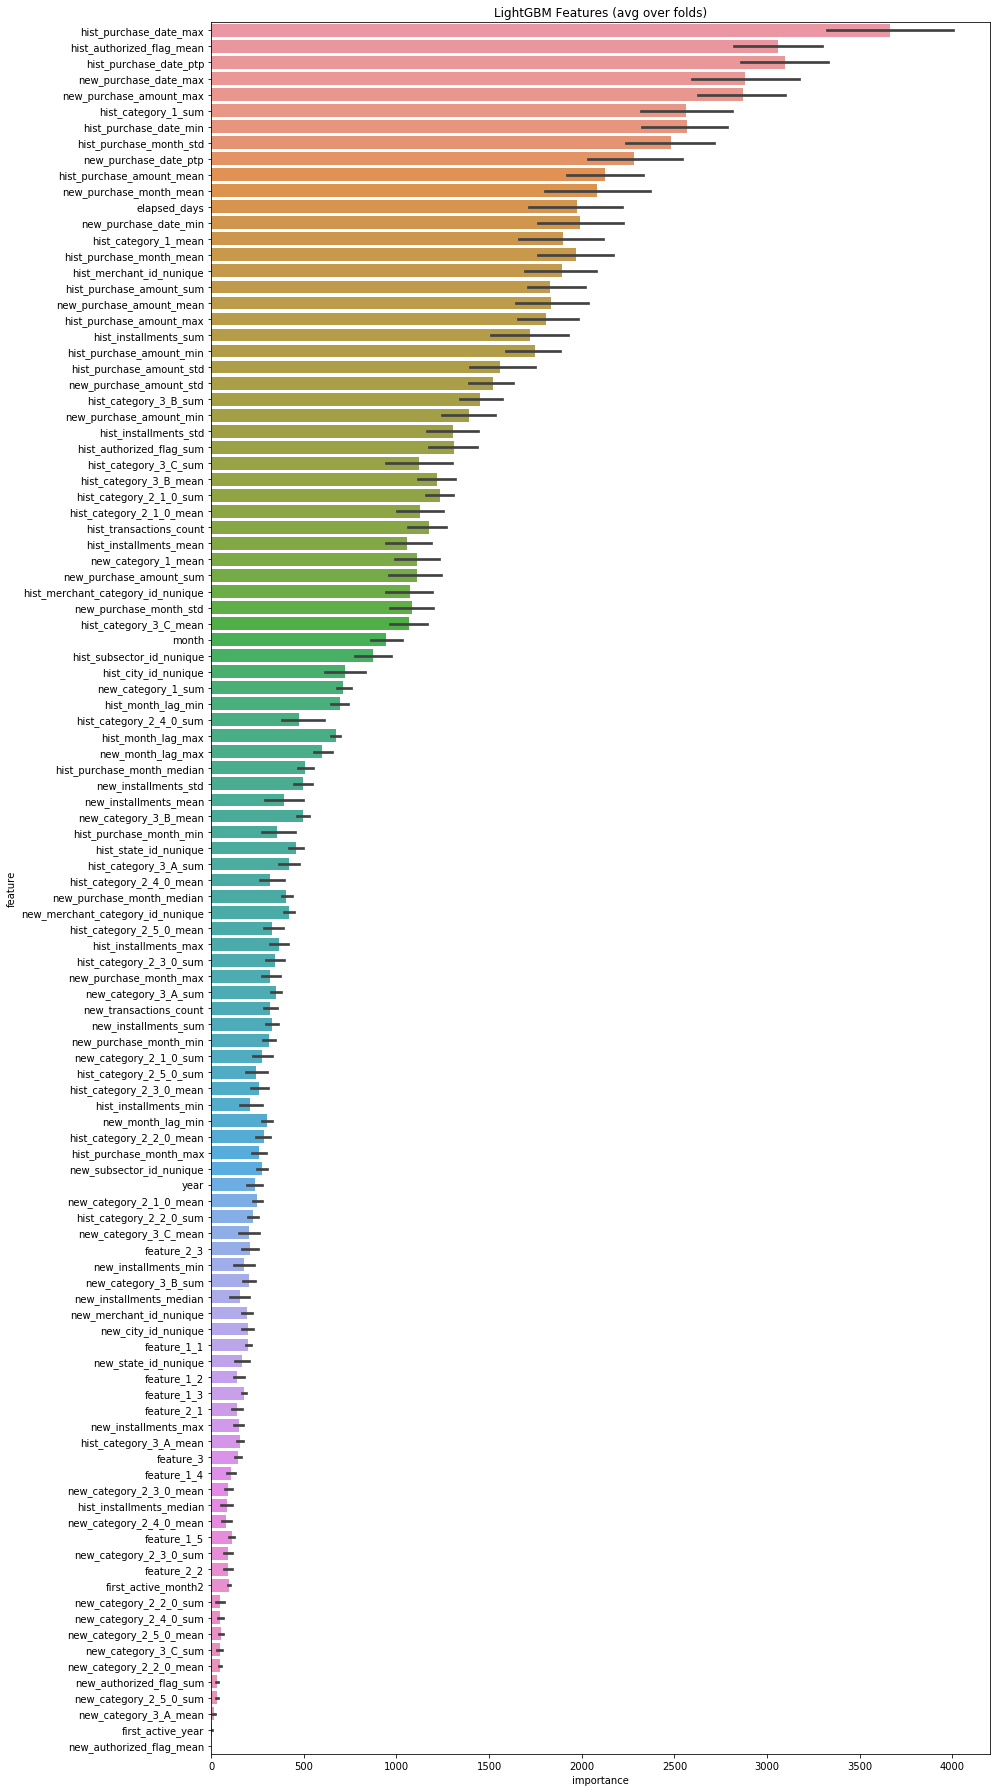

In [58]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
sorted(list(zip(clf.feature_importance(), features)), reverse=True)

In [63]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)

### XGBoost
For more details click [here](https://xgboost.readthedocs.io/en/latest/).

In [ ]:
xgb_params = {
    'eta': 0.005,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8, 
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': True
}

#folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))

feature_importance_xgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=df_train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(df_train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = xgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits

-
Fold 1
xgb 0--------------------------------------------------
[0]	train-rmse:3.93975	valid-rmse:3.9867
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.


In [ ]:
cross_validation_xgb = np.sqrt(mean_squared_error(target, oof_xgb))
print('Cross-validation score: ' + str(cross_validation_xgb))

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.savefig('xgboost_importances.png')

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/xgboost_{}.csv".format(cross_validation_lgb), index=False)